# STAFFING PLANNING OPTIMIZATION - CASE STUDY

An insurance company wants you to help them with finding the optimal number of staff that they need for their insurance application approval process. In the industry, the number of staff is considered a continuous variable. This is also called a Full-Time Equivalent (FTE) of the staff. 

The company can either handle an application with the staff that they hire or outsource it to a vendor. Assume that there is no capacity limitation to outsourcing.

If they hire staff, he/she can handle 40 insurance applications per month when he/she works 100% of the workdays. However, there are days that he/she will be unavailable to process applications due to training, off days, etc.

States A and B have a regulatory restriction that the outsourced insurance applications cannot be more than 30% and 40% of the total number of applications for each month, respectively.

The objective is to optimise the total cost for the application approval process by distributing the right number of applications between the FTEs and the vendors while meeting the monthly demand for each state at the same time.

Note: This program focuses on the analysis of Staffing Optimization when employees works at the average FTE.

In [1]:
import pandas as pd
import numpy as np
import math
from pyomo.environ import *

import warnings
warnings.filterwarnings('ignore')

In [2]:
from __future__ import division
from pyomo.opt import SolverFactory

In [4]:
# Reading the data from Excel workbook - demand tab
demand = pd.read_excel("/Users/rolanddelarosa/Downloads/StaffInsurance.xlsx",sheet_name='DemandData')

# Reading the data from Excel workbook - staff availablity tab
staff_data = pd.read_excel("/Users/rolanddelarosa/Downloads/StaffInsurance.xlsx",sheet_name='StaffAvailability')

# Reading the data from Excel workbook - Cost
cost = pd.read_excel("/Users/rolanddelarosa/Downloads/StaffInsurance.xlsx",sheet_name='Cost')

# Number of insurance applications that can be processed by an FTE in a month when working with 100% availability
srv_rate = 40

In [5]:
# Viewing the exported data
demand.head()

,State,Month,Demand
0,A,Jan,5240
1,A,Feb,4878
2,A,Mar,5942
3,A,Apr,2297
4,A,May,1992


In [6]:
# Viewing the exported data
staff_data.head()

,State,Month,LB,UB,StaffAvPer
0,A,Jan,0.70,0.90,0.81
1,A,Feb,0.65,0.85,0.76
2,A,Mar,0.70,0.80,0.75
3,A,Apr,0.75,0.85,0.80
4,A,May,0.70,0.85,0.78


In [7]:
# Viewing the exported data
cost.head()

,State,Month,AnnualSalary,MonthlySalary,UnitOutSourceCost
0,A,Jan,60000,5000.0,180
1,A,Feb,60000,5000.0,180
2,A,Mar,60000,5000.0,180
3,A,Apr,60000,5000.0,180
4,A,May,60000,5000.0,180


Data Pre-processing

In [8]:
# Creating unique index values from the dataset
month_name = demand['Month'].unique()
state_name = demand['State'].unique()
print("state :",state_name)
print("months :",month_name)

state : ['A' 'B' 'C']
months : ['Jan' 'Feb' 'Mar' 'Apr' 'May' 'Jun' 'Jul' 'Aug' 'Sep' 'Oct' 'Nov' 'Dec']


In [9]:
# Creating dict for the required parameters with [State, Month] as indexes

#Application Demand across State & Month
Demand_data = demand.set_index(['State','Month'])['Demand'].to_dict()

# Cost per Application for Outsource 
OutsourceRate = cost.set_index(['State','Month'])['UnitOutSourceCost'].to_dict()

# Cost for FTE monthly salary 
StaffMsal = cost.set_index(['State','Month'])['MonthlySalary'].to_dict()

# Staff availabilty for serving the Insurance - regular scenario , Lower bound , Upper bound scenario
StaffAvPer_data = staff_data.set_index(['State','Month'])['StaffAvPer'].to_dict()
StaffLB_data = staff_data.set_index(['State','Month'])['LB'].to_dict()
StaffUB_data = staff_data.set_index(['State','Month'])['UB'].to_dict()

Staff_app_permonth = 40

Question 1

The company wants to know the optimised staffing recommendations for the business case described. Write the mathematical model for the deterministic optimisation problem. Define and explain your decision variables, objective function and the constraint. (Hint: Use months of the year as the model timeline).

Answer to Question 1

Objective: The objective of the case study is to identify the optimal number of staff between Employees & Outsource such as to minimize the total cost for application approval process

Case Study Objective :

The objective of the case study is to identify the optimal number of staff between Employees & Outsource such as to minimize the total cost for application approval process

Decision Variables :

The objective indicates towards requirement of Cost & Count for developing the mathematical equation of the Objective Function. For Outsource - the cost is provided at per application basis & hence the 1st Variable  will be No. of Applications from Outsource named - Outsource_appl across states & months For Employess - the cost is provided as monthly salary & hence the  will be No. of FTE named - FTE_count across states & months

Objective Function :

To minimize the total cost for application approval process the Objective function will be :

x * 40 * a + y = D

where,

S = States
M = Months
c = Staff monthly salary
x = no. of FTE
O = Outsource Cost
y = No. of applications by outsource
a = Staff Availability %
D = Application Demand
40 = No. of Application per month by staff incase of 100% availability
Constraints

1. Demand per month per state

Before we create the Demand Constraint, we need to calculate a variable for No. of Applications being processed by FTEs.
- FTE_Appl = No. of FTE * StaffAvPer_data * Staff_app_permonth Demand_Constraint = FTE_Appl + Outsource_appl for each month for each state


2. Maximum Outsource for State A

State A can only provide 30% of the total application demand to outsource

3. Maximum Outsource for State B

State B can only provide 40% of the total application demand to outsource

Question 2

Code the problem is Python and use any optimization package to solve it. Add comments to your code to explain each step.

Expected output:

Create a data frame containing the number of outsourced applications and the number of FTEs for each state-month combination. You can choose to have extra columns like staff availability, demand etc. in your dataframe apart from the ones mentioned earlier.

In [10]:
# Creating a model instance
model = ConcreteModel()

Pyomo sets and Parameters

In [11]:
# Initializing month & state for usage in loops ahead
model.location = Set(initialize = state_name.tolist(),doc = 'States')
model.months = Set(initialize=month_name.tolist(), doc = 'Months')

In [12]:
model.location.display()

location : States
    Size=1, Index=None, Ordered=Insertion
    Key  : Dimen : Domain : Size : Members
    None :     1 :    Any :    3 : {'A', 'B', 'C'}


In [13]:
# Defining model Parameter for Demand across months & states
model.d = Param(model.location, model.months, initialize = Demand_data, doc = 'Demand')
model.d.display()

d : Demand
    Size=36, Index=d_index, Domain=Any, Default=None, Mutable=False
    Key          : Value
    ('A', 'Apr') :  2297
    ('A', 'Aug') :  3371
    ('A', 'Dec') :  5183
    ('A', 'Feb') :  4878
    ('A', 'Jan') :  5240
    ('A', 'Jul') :  5334
    ('A', 'Jun') :  2275
    ('A', 'Mar') :  5942
    ('A', 'May') :  1992
    ('A', 'Nov') :  4284
    ('A', 'Oct') :  3529
    ('A', 'Sep') :  3759
    ('B', 'Apr') :  2338
    ('B', 'Aug') :  2620
    ('B', 'Dec') :  4227
    ('B', 'Feb') :  2628
    ('B', 'Jan') :  4927
    ('B', 'Jul') :  4271
    ('B', 'Jun') :  3147
    ('B', 'Mar') :  2974
    ('B', 'May') :  4020
    ('B', 'Nov') :  3137
    ('B', 'Oct') :  4155
    ('B', 'Sep') :  4517
    ('C', 'Apr') :  2261
    ('C', 'Aug') :  2496
    ('C', 'Dec') :  1998
    ('C', 'Feb') :  1967
    ('C', 'Jan') :  1162
    ('C', 'Jul') :  2489
    ('C', 'Jun') :  1642
    ('C', 'Mar') :  1898
    ('C', 'May') :  2030
    ('C', 'Nov') :   963
    ('C', 'Oct') :  2421
    ('C', 'Sep') :   

In [14]:
# Defining model Parameter for Staff Availability across months & states
model.avail = Param(model.location, model.months, initialize = StaffAvPer_data, doc = 'Staff_Availability')
model.avail.display()

avail : Staff_Availability
    Size=36, Index=avail_index, Domain=Any, Default=None, Mutable=False
    Key          : Value
    ('A', 'Apr') :   0.8
    ('A', 'Aug') :  0.76
    ('A', 'Dec') :  0.65
    ('A', 'Feb') :  0.76
    ('A', 'Jan') :  0.81
    ('A', 'Jul') :  0.68
    ('A', 'Jun') :  0.73
    ('A', 'Mar') :  0.75
    ('A', 'May') :  0.78
    ('A', 'Nov') :  0.68
    ('A', 'Oct') :  0.73
    ('A', 'Sep') :  0.81
    ('B', 'Apr') :   0.8
    ('B', 'Aug') :  0.76
    ('B', 'Dec') :  0.65
    ('B', 'Feb') :  0.76
    ('B', 'Jan') :  0.81
    ('B', 'Jul') :  0.68
    ('B', 'Jun') :  0.73
    ('B', 'Mar') :  0.75
    ('B', 'May') :  0.78
    ('B', 'Nov') :  0.68
    ('B', 'Oct') :  0.73
    ('B', 'Sep') :  0.81
    ('C', 'Apr') :   0.8
    ('C', 'Aug') :  0.76
    ('C', 'Dec') :  0.65
    ('C', 'Feb') :  0.76
    ('C', 'Jan') :  0.81
    ('C', 'Jul') :  0.68
    ('C', 'Jun') :  0.73
    ('C', 'Mar') :  0.75
    ('C', 'May') :  0.78
    ('C', 'Nov') :  0.68
    ('C', 'Oct') :  0.73
 

In [15]:
# Defining model Parameter for Staff Monthly Salary across months & states
model.staffsalary = Param(model.location,model.months, initialize=StaffMsal, doc='Staff Monthly Salary')
model.staffsalary.display()


staffsalary : Staff Monthly Salary
    Size=36, Index=staffsalary_index, Domain=Any, Default=None, Mutable=False
    Key          : Value
    ('A', 'Apr') :            5000.0
    ('A', 'Aug') :            5000.0
    ('A', 'Dec') :            5000.0
    ('A', 'Feb') :            5000.0
    ('A', 'Jan') :            5000.0
    ('A', 'Jul') :            5000.0
    ('A', 'Jun') :            5000.0
    ('A', 'Mar') :            5000.0
    ('A', 'May') :            5000.0
    ('A', 'Nov') :            5000.0
    ('A', 'Oct') :            5000.0
    ('A', 'Sep') :            5000.0
    ('B', 'Apr') : 4583.333333333333
    ('B', 'Aug') : 4583.333333333333
    ('B', 'Dec') : 4583.333333333333
    ('B', 'Feb') : 4583.333333333333
    ('B', 'Jan') : 4583.333333333333
    ('B', 'Jul') : 4583.333333333333
    ('B', 'Jun') : 4583.333333333333
    ('B', 'Mar') : 4583.333333333333
    ('B', 'May') : 4583.333333333333
    ('B', 'Nov') : 4583.333333333333
    ('B', 'Oct') : 4583.333333333333
    ('B', '

In [16]:
# Defining model Parameter for Outsource Cost across months & states
model.outsourcecost = Param(model.location, model.months, initialize = OutsourceRate, doc = 'Outsource Cost')
model.outsourcecost.display()

outsourcecost : Outsource Cost
    Size=36, Index=outsourcecost_index, Domain=Any, Default=None, Mutable=False
    Key          : Value
    ('A', 'Apr') :   180
    ('A', 'Aug') :   180
    ('A', 'Dec') :   180
    ('A', 'Feb') :   180
    ('A', 'Jan') :   180
    ('A', 'Jul') :   180
    ('A', 'Jun') :   180
    ('A', 'Mar') :   180
    ('A', 'May') :   180
    ('A', 'Nov') :   180
    ('A', 'Oct') :   180
    ('A', 'Sep') :   180
    ('B', 'Apr') :   150
    ('B', 'Aug') :   150
    ('B', 'Dec') :   150
    ('B', 'Feb') :   150
    ('B', 'Jan') :   150
    ('B', 'Jul') :   150
    ('B', 'Jun') :   150
    ('B', 'Mar') :   150
    ('B', 'May') :   150
    ('B', 'Nov') :   150
    ('B', 'Oct') :   150
    ('B', 'Sep') :   150
    ('C', 'Apr') :   160
    ('C', 'Aug') :   160
    ('C', 'Dec') :   160
    ('C', 'Feb') :   160
    ('C', 'Jan') :   160
    ('C', 'Jul') :   160
    ('C', 'Jun') :   160
    ('C', 'Mar') :   160
    ('C', 'May') :   160
    ('C', 'Nov') :   160
    ('C', 'Oct

Decision Variables

In [17]:
# Decision variables
model.x = Var(model.location, model.months, domain=NonNegativeReals, doc='No. of FTE')
model.y = Var(model.location, model.months, domain=NonNegativeIntegers, doc='No. of Outsource Appl.')

Objective Function

In [18]:
obj = 0
def obj_rule(model):
    global obj
    for l in model.location:
        for m in model.months:
            # formula used is : (Outsource Appl * per Appl cost for Outsource) + (no. of FTEs * Monthly Salary)
            obj+=(model.y[l,m]*model.outsourcecost[l,m])+(model.x[l,m]*model.staffsalary[l,m])
    return obj
model.output = Objective(rule=obj_rule, sense= minimize)

Constraints - Demand Constraint

In [19]:
model.ddConst = ConstraintList()
for l in model.location:
    for m in model.months:
        model.ddConst.add(expr = model.y[l,m] + model.x[l,m]*(model.avail[l,m]*40) == model.d[l,m]) 
        # Demand = No. of Outsource Applications + (FTE count* Max Application,i.e.,'40' * Staff Availability %)

Constraints - State A Outsourcing Constraint

In [20]:
model.statelimit = ConstraintList()

for l in model.location:
    for m in model.months:
        if l == 'A':
            model.statelimit.add(expr = model.y[l,m] <= 0.3*model.d[l,m])
        elif l == 'B':
            model.statelimit.add(expr = model.y[l,m] <= 0.4*model.d[l,m])
        else:
            pass

Invoking Solver

In [21]:
from pyomo.opt import SolverFactory

# Specify the full path to the glpsol executable
solver_path = '/opt/homebrew/bin/glpsol' 

# Invoking the solver
result = SolverFactory('glpk', executable=solver_path).solve(model)
result.write()

# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown
  Lower bound: 17962336.4487699
  Upper bound: 17962336.4487699
  Number of objectives: 1
  Number of constraints: 60
  Number of variables: 72
  Number of nonzeros: 96
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Termination condition: optimal
  Statistics: 
    Branch and bound: 
      Number of bounded subproblems: 0
      Number of created subproblems: 0
  Error rc: 0
  Time: 0.01031494140625
# ----------------------------------------------------------
#   Solution Information
# ---------------

In [22]:
# Print the value of the objective function (converting the output to million)
base_cost = int(model.output())/10**6
base_cost

17.962336

The company has to spend approzimately around 17.9 m$ in total for the application approval process.

In [23]:
# Creating dataframe for the results
# optimal number of staff members for the Avg case scenario
Avg_Output = []
Avg_avilb = 0

for l in model.location:
    for m in model.months:
        
        # optimal no. of staff members for Avg Case scenario
        Staff_count = (round(model.x[l,m].value))
        
        # outsourced applications% = no. of Outsource applications(stored in variable y) divide by total demand(stored in variable d)*100
        Outsource_applications = (model.y[l,m].value)
        
        # Total Cost = cost of staff + Cost of   outsourced  applications
                
        Avg_Output.append([l,m, Staff_count, Outsource_applications])
       
                
print(Avg_Output)


[['A', 'Jan', 162, 0.0], ['A', 'Feb', 160, 0.0], ['A', 'Mar', 198, 0.0], ['A', 'Apr', 72, 0.0], ['A', 'May', 64, 0.0], ['A', 'Jun', 78, 0.0], ['A', 'Jul', 137, 1600.0], ['A', 'Aug', 111, 0.0], ['A', 'Sep', 116, 0.0], ['A', 'Oct', 121, 0.0], ['A', 'Nov', 110, 1285.0], ['A', 'Dec', 140, 1554.0], ['B', 'Jan', 152, 0.0], ['B', 'Feb', 52, 1051.0], ['B', 'Mar', 60, 1189.0], ['B', 'Apr', 73, 0.0], ['B', 'May', 129, 0.0], ['B', 'Jun', 65, 1258.0], ['B', 'Jul', 94, 1708.0], ['B', 'Aug', 52, 1048.0], ['B', 'Sep', 139, 0.0], ['B', 'Oct', 85, 1662.0], ['B', 'Nov', 69, 1254.0], ['B', 'Dec', 98, 1690.0], ['C', 'Jan', 36, 0.0], ['C', 'Feb', 65, 0.0], ['C', 'Mar', 63, 0.0], ['C', 'Apr', 71, 0.0], ['C', 'May', 65, 0.0], ['C', 'Jun', 56, 0.0], ['C', 'Jul', 0, 2489.0], ['C', 'Aug', 82, 0.0], ['C', 'Sep', 28, 0.0], ['C', 'Oct', 83, 0.0], ['C', 'Nov', 0, 963.0], ['C', 'Dec', 0, 1998.0]]


In [24]:
Avg_Output = pd.DataFrame(Avg_Output, columns=['State','Month','Optimal Staff_AvgCase','Out_Appl_AvgCase'])
Avg_Output


,State,Month,Optimal Staff_AvgCase,Out_Appl_AvgCase
0,A,Jan,162,0.0
1,A,Feb,160,0.0
2,A,Mar,198,0.0
3,A,Apr,72,0.0
4,A,May,64,0.0
5,A,Jun,78,0.0
6,A,Jul,137,1600.0
7,A,Aug,111,0.0
8,A,Sep,116,0.0
9,A,Oct,121,0.0


In [25]:
# Importing the required library
from openpyxl import load_workbook

In [28]:
# Writing the results in to an Excel sheet
# Writing the output data into an Excel sheet named "Staffing_Data.xlsx" workbook


book = load_workbook("/Users/rolanddelarosa/Downloads/StaffInsurance.xlsx")

# create excel writer object
writer = pd.ExcelWriter("/Users/rolanddelarosa/Downloads/StaffInsurance.xlsx", engine = 'openpyxl')


#Assigning the workbook to the writer object
writer.book = book


# write dataframe to excel sheet named 'output'
Avg_Output.to_excel(writer, sheet_name='Output_Staff_Planning_Avg')



# save the excel file
writer.save()
print('DataFrame is written successfully to Excel Sheet.')

DataFrame is written successfully to Excel Sheet.


In [31]:
# creating dataframe to record the Overall output of Average Scenario for further scenario

from statistics import mean
final_output = []
appl_cost = 0
out_appl = 0
for l in model.location:
    for m in model.months:
            
            cost_per_appl=((model.y[l,m].value*model.outsourcecost[l,m])+(model.x[l,m].value*model.staffsalary[l,m]))/model.d[l,m]
            appl_cost+=cost_per_appl
            final_output.append(cost_per_appl)
            out_appl+= model.y[l,m].value
            
base_mean = mean(final_output)
overall_df = pd.DataFrame(data={(round(base_mean,1),round(appl_cost,1),round(base_cost,2),round(out_appl,))},index=['Base Scenario'],columns=['Avg_cost_per_appl','tot_cost_per_appl','Overall Cost_in $mio','Outsource_Appl_count'])
overall_df

,Avg_cost_per_appl,tot_cost_per_appl,Overall Cost_in $mio,Outsource_Appl_count
Base Scenario,155.9,5611.7,17.96,20749


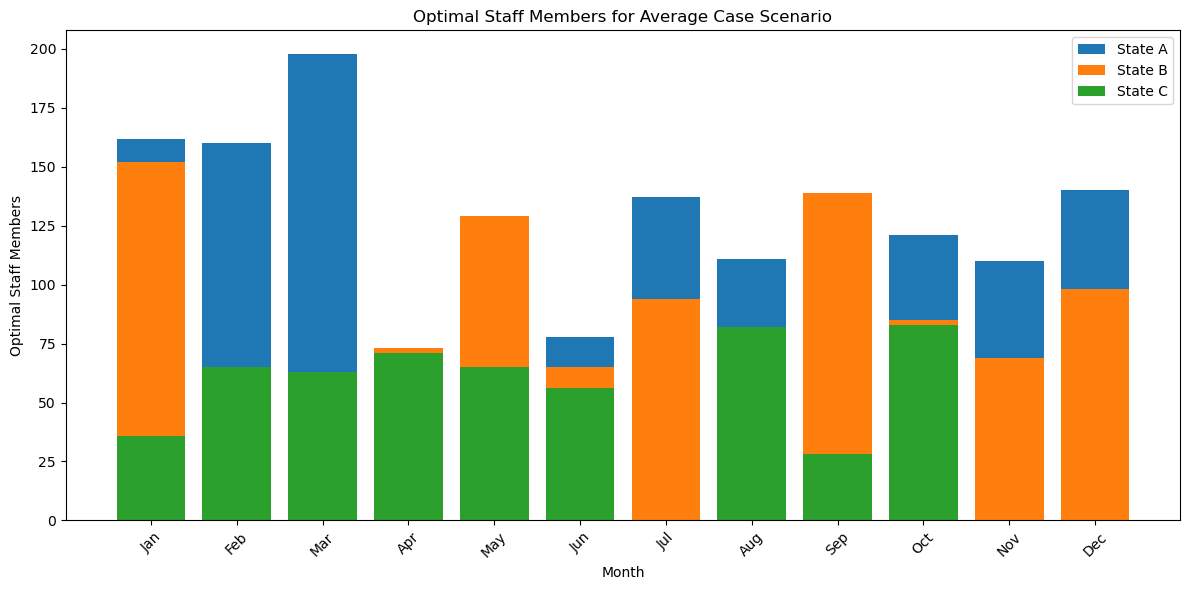

In [35]:
import matplotlib.pyplot as plt

# Bar chart for optimal staff members
plt.figure(figsize=(12, 6))
for state in Avg_Output['State'].unique():
    data = Avg_Output[Avg_Output['State'] == state]
    plt.bar(data['Month'], data['Optimal Staff_AvgCase'], label=f'State {state}')

plt.xlabel('Month')
plt.ylabel('Optimal Staff Members')
plt.title('Optimal Staff Members for Average Case Scenario')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


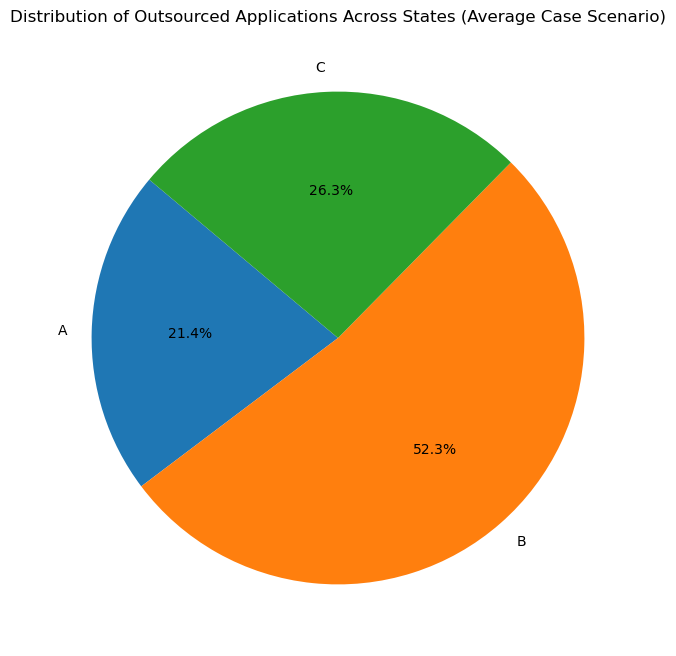

In [36]:
# Pie chart for outsourced applications distribution
outsourced_counts = Avg_Output.groupby('State')['Out_Appl_AvgCase'].sum()
plt.figure(figsize=(8, 8))
plt.pie(outsourced_counts, labels=outsourced_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Outsourced Applications Across States (Average Case Scenario)')
plt.show()



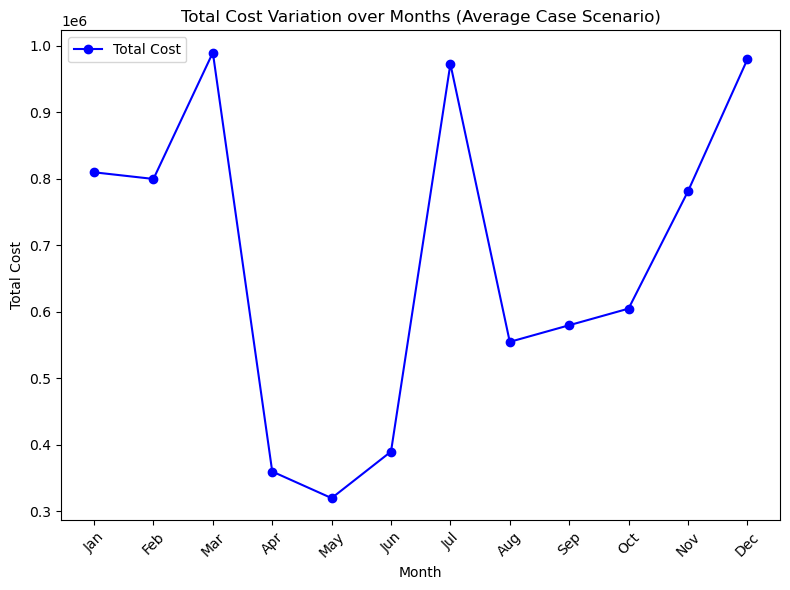

In [39]:
import pandas as pd
import matplotlib.pyplot as plt

# Sample data (replace this with your actual data)
data = {
    'Month': ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'],
    'Optimal Staff_AvgCase': [162, 160, 198, 72, 64, 78, 137, 111, 116, 121, 110, 140],
    'Staff Monthly Salary': [5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000],
    'Out_Appl_AvgCase': [0, 0, 0, 0, 0, 0, 1600, 0, 0, 0, 1285, 1554],
    'UnitOutSourceCost': [180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180]
}

Avg_Output = pd.DataFrame(data)

# Calculate total cost
Avg_Output['Total Cost'] = (Avg_Output['Optimal Staff_AvgCase'] * Avg_Output['Staff Monthly Salary'] +
                            Avg_Output['Out_Appl_AvgCase'] * Avg_Output['UnitOutSourceCost'])

# Line chart for total cost variation over months
months = Avg_Output['Month']
total_cost = Avg_Output['Total Cost']

plt.figure(figsize=(8, 6))
plt.plot(months, total_cost, marker='o', color='b', label='Total Cost')
plt.xlabel('Month')
plt.ylabel('Total Cost')
plt.title('Total Cost Variation over Months (Average Case Scenario)')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()
